In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

<h5 style="color: SkyBlue;">Load Dataset</h5>

In [2]:
df = pd.read_csv('user_data_for_disease_prediction - unclassified data set.csv')
print(df.head())

   Heart Rate (bpm)  Breathing Rate (brpm)  Oxygen Saturation (%)  \
0              80.3                   12.2                   96.4   
1              73.1                   17.7                   95.9   
2              72.2                   18.0                   96.0   
3              70.6                   14.7                   95.1   
4              99.5                   19.5                   97.6   

   Blood Pressure (systolic)  Blood Pressure (diastolic)  Stress Index  \
0                      107.3                        74.2          39.6   
1                       92.4                        70.8          98.7   
2                      102.4                        75.6          45.3   
3                      110.0                        62.2          77.8   
4                      110.2                        73.0          57.3   

   Recovery Ability  PNS Index  SNS Index  RMSSD (ms)  SD2 (ms)  \
0                 0       -0.9        0.4        49.7      67.9   
1     

In [3]:
# handle missing values 
df.fillna(0, inplace=True)

<h5 style="color: SkyBlue;">Ranking of diseases in the dataset</h5>

In [4]:
def classify_disease(row):
    gender = row["Gender (0-M;1-F)"]

    # Hypertension
    if (
        row["Blood Pressure (systolic)"] > 130 or row["Blood Pressure (diastolic)"] > 80
    ) and (row["Heart Rate (bpm)"] >= 60 and row["Heart Rate (bpm)"] <= 100):
        return "Hypertension"

    # Atherosclerosis (distinct criteria for this condition)
    elif row["Blood Pressure (systolic)"] > 140 or row["Hemoglobin A1c (%)"] > 7.0:
        return "Atherosclerosis"

    # Cardiovascular Disease (CVD)
    elif (row["Heart Rate (bpm)"] > 100 or row["Heart Rate (bpm)"] < 60) or (
        row["Blood Pressure (systolic)"] > 140 or row["Blood Pressure (diastolic)"] > 90
    ):
        return "Cardiovascular Disease (CVD)"

    # Respiratory Disease (COPD or Asthma)
    elif row["Breathing Rate (brpm)"] > 20 or row["Oxygen Saturation (%)"] < 90:
        return "Respiratory Disease (COPD or Asthma)"

    # Chronic Fatigue Syndrome (CFS)
    elif (
        row["HRV SDNN (ms)"] < 50
        or row["RMSSD (ms)"] < 30
        or row["Recovery Ability"] == 0
    ):
        return "Chronic Fatigue Syndrome (CFS)"

    # Diabetes
    elif row["Hemoglobin A1c (%)"] > 6.5:
        return "Diabetes"

    # Arrhythmias
    elif row["HRV SDNN (ms)"] > 100 or row["Mean RRI (ms)"] < 600:
        return "Arrhythmias"

    # Stress-related Disorders
    elif row["Stress Index"] > 70 or row["SNS Index"] > 1.0:
        return "Stress-related Disorders"

    # Autonomic Dysfunction
    elif row["PNS Index"] < -1.0 or row["SNS Index"] > 1.0:
        return "Autonomic Dysfunction"

    # Anaemia (adjusted for gender)
    elif (gender == 0 and row["Hemoglobin (g/dl)"] < 13.5) or (
        gender == 1 and row["Hemoglobin (g/dl)"] < 12.0
    ):
        return "Anaemia"

    # If none of the conditions are met, classify as Healthy
    else:
        return "Healthy"


# Apply the updated classify_disease function to each row and create a new column for the disease
df["Disease"] = df.apply(classify_disease, axis=1)

# Count occurrences of each disease
disease_counts = df["Disease"].value_counts()

# Sort counts in descending order and display the results
disease_counts_sorted = disease_counts.sort_values(ascending=False)
print(disease_counts_sorted)

Disease
Atherosclerosis                         152809
Hypertension                            115644
Cardiovascular Disease (CVD)             99122
Chronic Fatigue Syndrome (CFS)           53545
Respiratory Disease (COPD or Asthma)     28039
Stress-related Disorders                   352
Arrhythmias                                284
Healthy                                     67
Autonomic Dysfunction                       65
Diabetes                                    48
Anaemia                                     25
Name: count, dtype: int64


In [5]:
sampled_df_health = df.sample(n=200000, random_state=42)

# Count occurrences of each disease
sampled_disease_counts = sampled_df_health["Disease"].value_counts()

# Sort counts in descending order and display the results
sampled_disease_counts_sorted = sampled_disease_counts.sort_values(ascending=False)
print(sampled_disease_counts_sorted)

Disease
Atherosclerosis                         67905
Hypertension                            51521
Cardiovascular Disease (CVD)            43988
Chronic Fatigue Syndrome (CFS)          23828
Respiratory Disease (COPD or Asthma)    12376
Stress-related Disorders                  155
Arrhythmias                               136
Healthy                                    31
Autonomic Dysfunction                      29
Diabetes                                   24
Anaemia                                     7
Name: count, dtype: int64


<h5 style="color: SkyBlue;">Synthetic sampling</h5>

In [6]:
###
# Combination of SMOTE and ENN (Edited Nearest Neighbours) keeps relevant samples from the majority classes
# while synthetically balancing the minority classes
# ###

# Feature (X) and target (y) separation
X = sampled_df_health.drop("Disease", axis=1)
y = sampled_df_health["Disease"]

# Initialise SMOTE with custom parameters
smote = SMOTE(k_neighbors=2, random_state=42)

# Pass the SMOTE instance to SMOTEENN
smote_enn = SMOTEENN(random_state=42, smote=smote)
X_balanced, y_balanced = smote_enn.fit_resample(X, y)

# Display the number of records in the balanced dataset
balanced_data_counts = {
    "Balanced Feature Shape ": X_balanced.shape,
    "Balanced Target Shape ": y_balanced.shape,
    "Balanced Distribution after SMOTEENN ": y_balanced.value_counts()
}

balanced_data_counts

{'Balanced Feature Shape ': (651932, 17),
 'Balanced Target Shape ': (651932,),
 'Balanced Distribution after SMOTEENN ': Disease
 Anaemia                                 67905
 Arrhythmias                             67905
 Autonomic Dysfunction                   67905
 Stress-related Disorders                67905
 Diabetes                                67905
 Healthy                                 67905
 Chronic Fatigue Syndrome (CFS)          66792
 Respiratory Disease (COPD or Asthma)    66781
 Hypertension                            48966
 Cardiovascular Disease (CVD)            38457
 Atherosclerosis                         23506
 Name: count, dtype: int64}

<h5 style="color: SkyBlue;">Logistic Regression</h5>

c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\sklearn\linear_model\_logi

Classification Report:
                                       precision    recall  f1-score   support

                             Anaemia       0.99      1.00      0.99     13532
                         Arrhythmias       0.78      0.83      0.81     13507
                     Atherosclerosis       0.92      0.71      0.80      4607
               Autonomic Dysfunction       0.87      0.98      0.93     13799
        Cardiovascular Disease (CVD)       0.88      0.86      0.87      7690
      Chronic Fatigue Syndrome (CFS)       0.93      0.96      0.94     13223
                            Diabetes       0.83      0.83      0.83     13576
                             Healthy       0.90      1.00      0.95     13524
                        Hypertension       0.80      0.74      0.77      9901
Respiratory Disease (COPD or Asthma)       0.82      0.67      0.74     13353
            Stress-related Disorders       0.83      0.81      0.82     13675

                            accuracy  

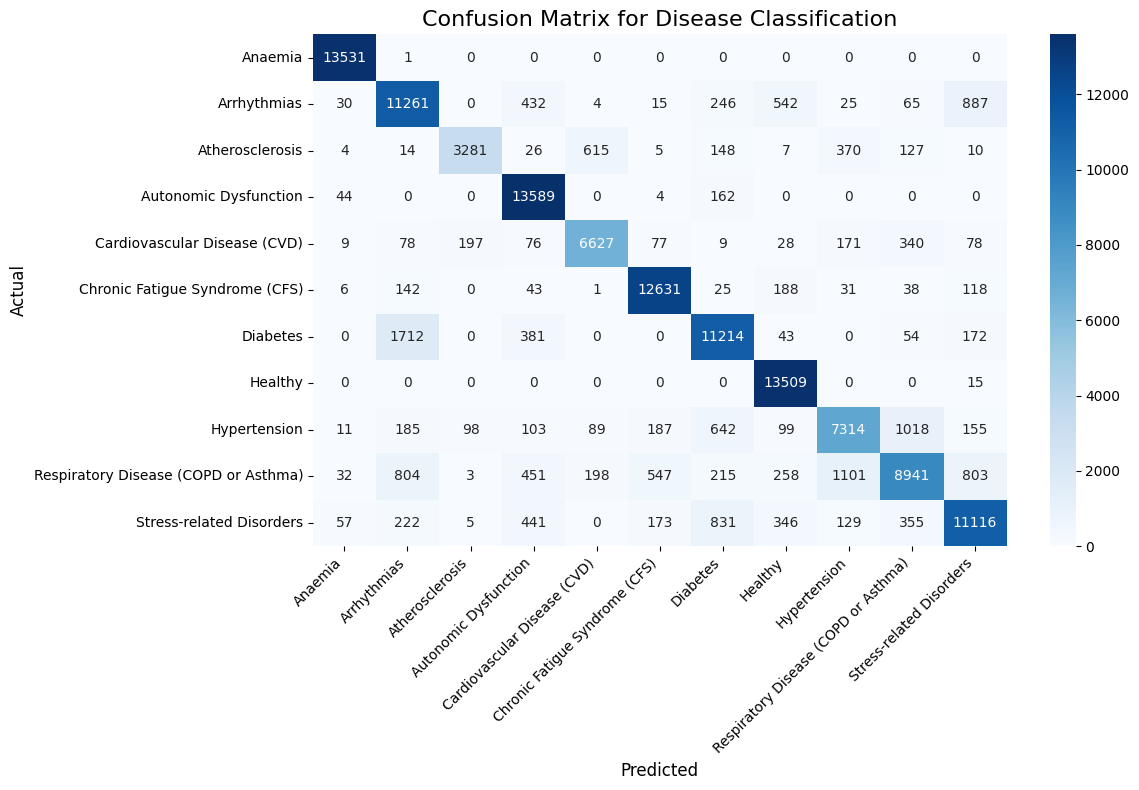

In [7]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_balanced)  # Encode the balanced target

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_encoded, test_size=0.2, random_state=42
)

model = LogisticRegression(
    max_iter=1000, class_weight='balanced', multi_class='ovr', random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

print("Classification Report:\n", classification_report(y_test_decoded, y_pred_decoded))

accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy:.2f}")

conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=label_encoder.classes_)

# confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Disease Classification', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h5 style="color: SkyBlue;">Decision Tree</h5>

Decision Tree - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13532
           1       1.00      1.00      1.00     13507
           2       1.00      1.00      1.00      4607
           3       1.00      1.00      1.00     13799
           4       1.00      1.00      1.00      7690
           5       1.00      1.00      1.00     13223
           6       1.00      1.00      1.00     13576
           7       1.00      1.00      1.00     13524
           8       1.00      1.00      1.00      9901
           9       1.00      1.00      1.00     13353
          10       1.00      1.00      1.00     13675

    accuracy                           1.00    130387
   macro avg       1.00      1.00      1.00    130387
weighted avg       1.00      1.00      1.00    130387

Decision Tree - Accuracy: 0.9992560608036077


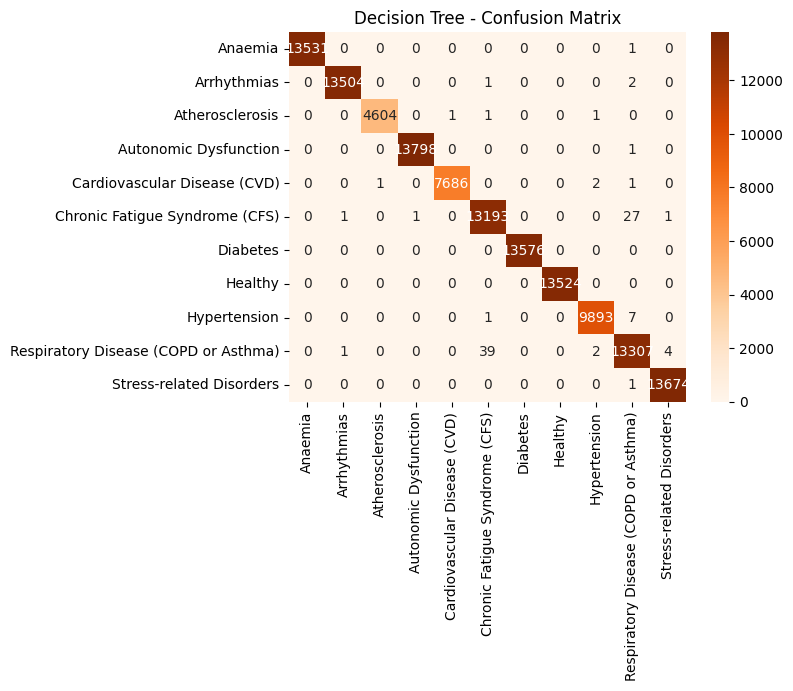

In [8]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

print("Decision Tree - Classification Report")
print(classification_report(y_test, y_pred_dt))
print("Decision Tree - Accuracy:", accuracy_score(y_test, y_pred_dt))

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(conf_matrix_dt, annot=True, cmap='Oranges', fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Decision Tree - Confusion Matrix')
plt.show()

<h5 style="color: SkyBlue;">Random Forest</h5>

Random Forest - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13532
           1       1.00      1.00      1.00     13507
           2       1.00      1.00      1.00      4607
           3       1.00      1.00      1.00     13799
           4       1.00      1.00      1.00      7690
           5       1.00      1.00      1.00     13223
           6       1.00      1.00      1.00     13576
           7       1.00      1.00      1.00     13524
           8       1.00      1.00      1.00      9901
           9       1.00      1.00      1.00     13353
          10       1.00      1.00      1.00     13675

    accuracy                           1.00    130387
   macro avg       1.00      1.00      1.00    130387
weighted avg       1.00      1.00      1.00    130387

Random Forest - Accuracy: 0.9996088567111752


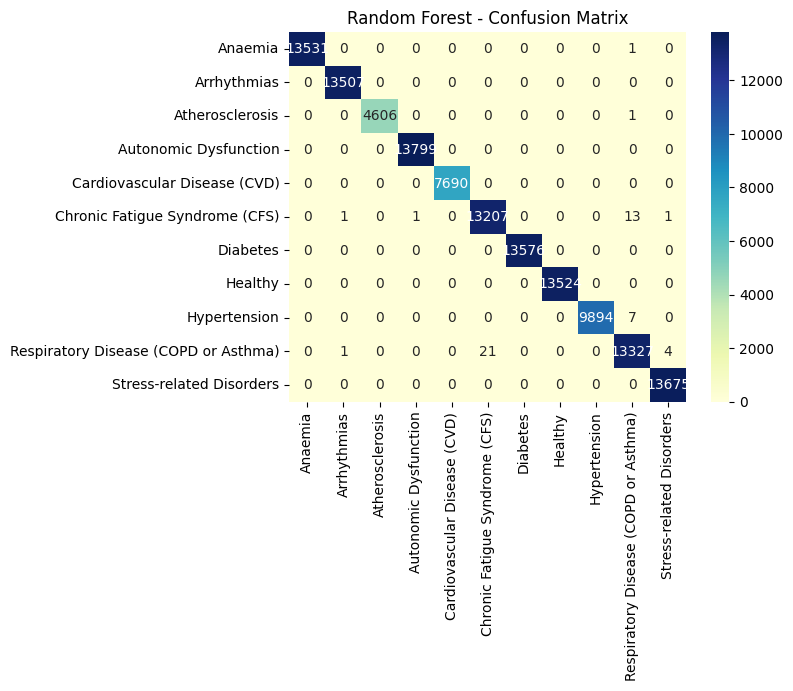

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))
print("Random Forest - Accuracy:", accuracy_score(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, cmap='YlGnBu', fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Random Forest - Confusion Matrix')
plt.show()

<h5 style="color: SkyBlue;">GBM</h5>

Gradient Boosting Model - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13532
           1       1.00      1.00      1.00     13507
           2       1.00      1.00      1.00      4607
           3       1.00      1.00      1.00     13799
           4       1.00      1.00      1.00      7690
           5       1.00      1.00      1.00     13223
           6       1.00      1.00      1.00     13576
           7       1.00      1.00      1.00     13524
           8       1.00      1.00      1.00      9901
           9       1.00      1.00      1.00     13353
          10       1.00      1.00      1.00     13675

    accuracy                           1.00    130387
   macro avg       1.00      1.00      1.00    130387
weighted avg       1.00      1.00      1.00    130387

Gradient Boosting Model - Accuracy: 0.999309747137368


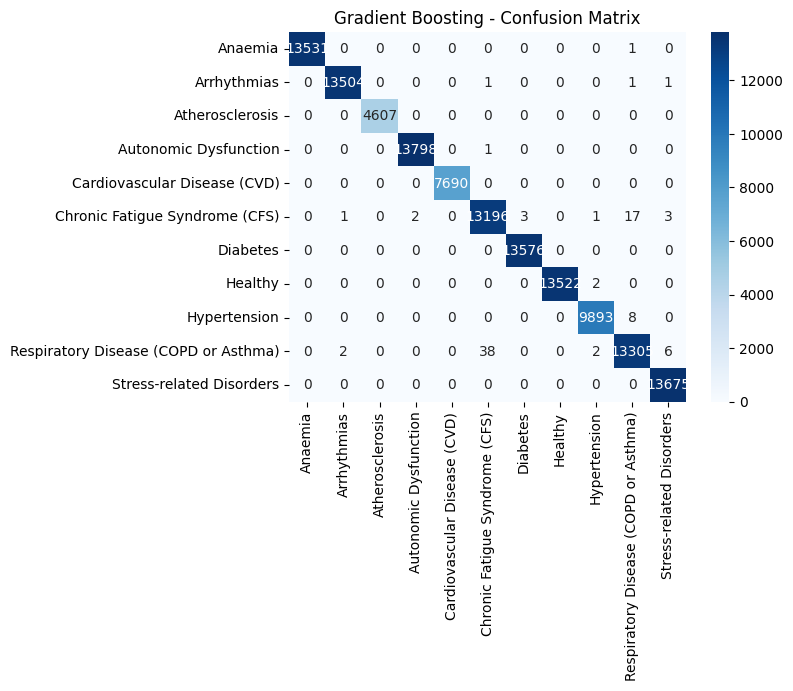

In [17]:
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm.fit(X_train, y_train)

y_pred_gbm = gbm.predict(X_test)

print("Gradient Boosting Model - Classification Report")
print(classification_report(y_test, y_pred_gbm))

print("Gradient Boosting Model - Accuracy:", accuracy_score(y_test, y_pred_gbm))

# confusion Matrix
conf_matrix_gbm = confusion_matrix(y_test, y_pred_gbm)
sns.heatmap(conf_matrix_gbm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Gradient Boosting - Confusion Matrix')
plt.show()

<h5 style="color: SkyBlue;">KNN</h5>

K-Nearest Neighbors Model - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13532
           1       1.00      1.00      1.00     13507
           2       0.97      0.92      0.94      4607
           3       1.00      1.00      1.00     13799
           4       0.96      0.96      0.96      7690
           5       0.99      0.99      0.99     13223
           6       1.00      1.00      1.00     13576
           7       1.00      1.00      1.00     13524
           8       0.99      0.95      0.97      9901
           9       0.96      1.00      0.98     13353
          10       1.00      1.00      1.00     13675

    accuracy                           0.99    130387
   macro avg       0.99      0.98      0.99    130387
weighted avg       0.99      0.99      0.99    130387

K-Nearest Neighbors Model - Accuracy: 0.990075697730602


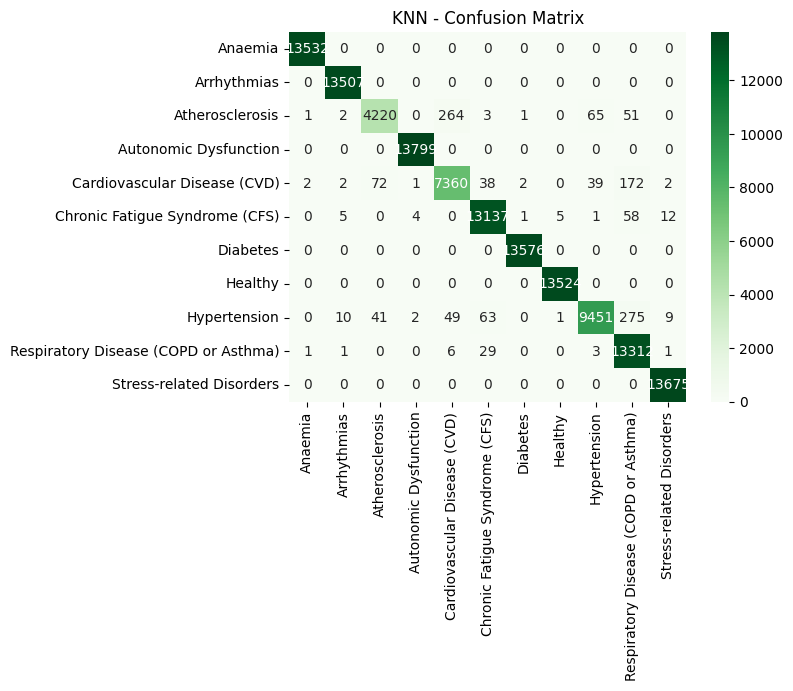

In [11]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print("K-Nearest Neighbors Model - Classification Report")
print(classification_report(y_test, y_pred_knn))

print("K-Nearest Neighbors Model - Accuracy:", accuracy_score(y_test, y_pred_knn))

# confusion Matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(conf_matrix_knn, annot=True, cmap='Greens', fmt='d', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('KNN - Confusion Matrix')
plt.show()

<h5 style="color: SkyBlue;">LightGBM</h5>

LightGBM - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13532
           1       0.12      1.00      0.21     13507
           2       0.00      0.00      0.00      4607
           3       0.00      0.00      0.00     13799
           4       0.00      0.00      0.00      7690
           5       0.00      0.00      0.00     13223
           6       0.00      0.00      0.00     13576
           7       0.00      0.00      0.00     13524
           8       0.00      0.00      0.00      9901
           9       0.00      0.00      0.00     13353
          10       0.00      0.00      0.00     13675

    accuracy                           0.21    130387
   macro avg       0.10      0.18      0.11    130387
weighted avg       0.12      0.21      0.13    130387

LightGBM - Accuracy: 0.207367298887159


c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

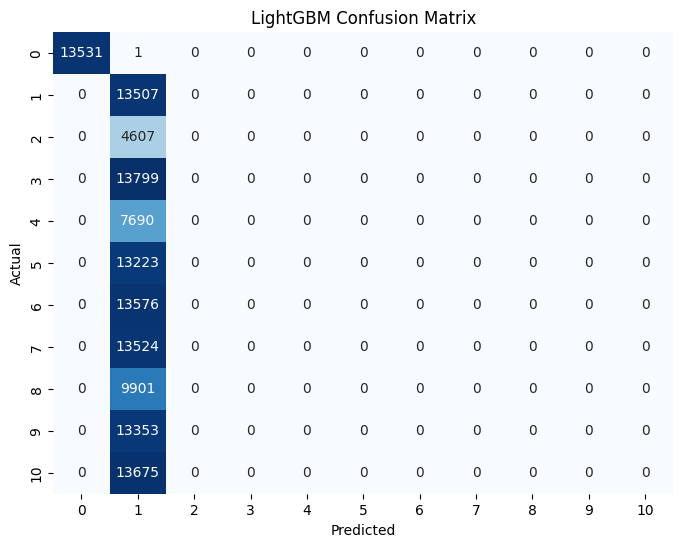

In [14]:
train_data = lgb.Dataset(X_train, label=y_train)

params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'verbosity': -1
}
lgb_model = lgb.train(params, train_data, num_boost_round=100)

y_pred_lgb = (lgb_model.predict(X_test) >= 0.5).astype(int)

print("LightGBM - Classification Report")
print(classification_report(y_test, y_pred_lgb))
print("LightGBM - Accuracy:", accuracy_score(y_test, y_pred_lgb))

# confusion  matrix
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgb, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<h5 style="color: SkyBlue;">XGBoost</h5>

c:\Users\zen\Documents\les trucs du boulot\TM R&D\E-Health\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:13:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13532
           1       1.00      1.00      1.00     13507
           2       1.00      0.99      0.99      4607
           3       1.00      1.00      1.00     13799
           4       1.00      1.00      1.00      7690
           5       1.00      1.00      1.00     13223
           6       1.00      1.00      1.00     13576
           7       1.00      1.00      1.00     13524
           8       1.00      1.00      1.00      9901
           9       1.00      1.00      1.00     13353
          10       1.00      1.00      1.00     13675

    accuracy                           1.00    130387
   macro avg       1.00      1.00      1.00    130387
weighted avg       1.00      1.00      1.00    130387

XGBoost Model - Accuracy: 0.9988189006572741


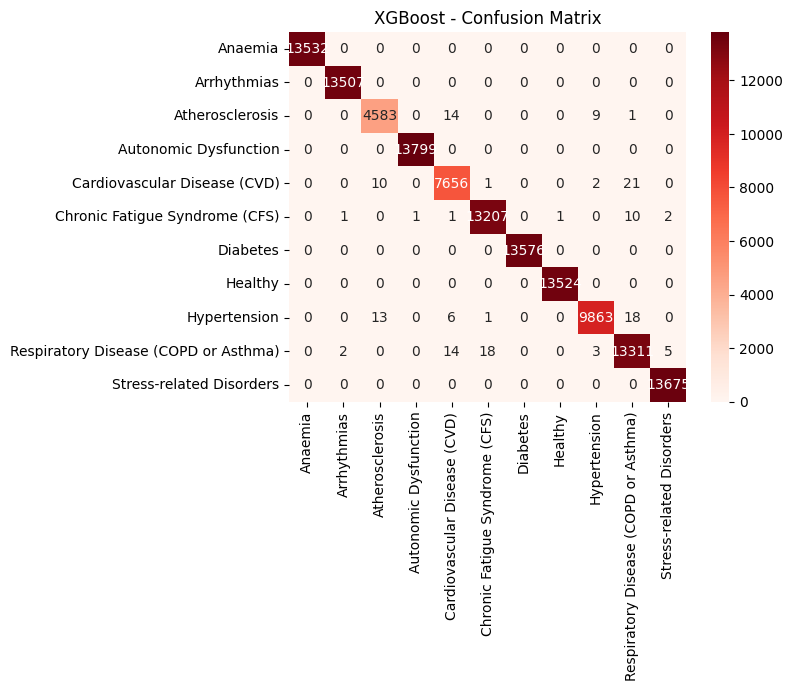

In [15]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Model - Classification Report")
print(classification_report(y_test, y_pred_xgb))

print("XGBoost Model - Accuracy:", accuracy_score(y_test, y_pred_xgb))

# confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, cmap='Reds', fmt='d', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('XGBoost - Confusion Matrix')
plt.show()

<h5 style="color: SkyBlue;">ExtraTreesClassifier</h5>

ExtraTrees - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13532
           1       1.00      1.00      1.00     13507
           2       1.00      0.98      0.99      4607
           3       1.00      1.00      1.00     13799
           4       0.99      1.00      0.99      7690
           5       1.00      0.99      1.00     13223
           6       1.00      1.00      1.00     13576
           7       1.00      1.00      1.00     13524
           8       1.00      0.99      0.99      9901
           9       0.99      1.00      0.99     13353
          10       1.00      1.00      1.00     13675

    accuracy                           1.00    130387
   macro avg       1.00      1.00      1.00    130387
weighted avg       1.00      1.00      1.00    130387

ExtraTrees - Accuracy: 0.9980059361746186


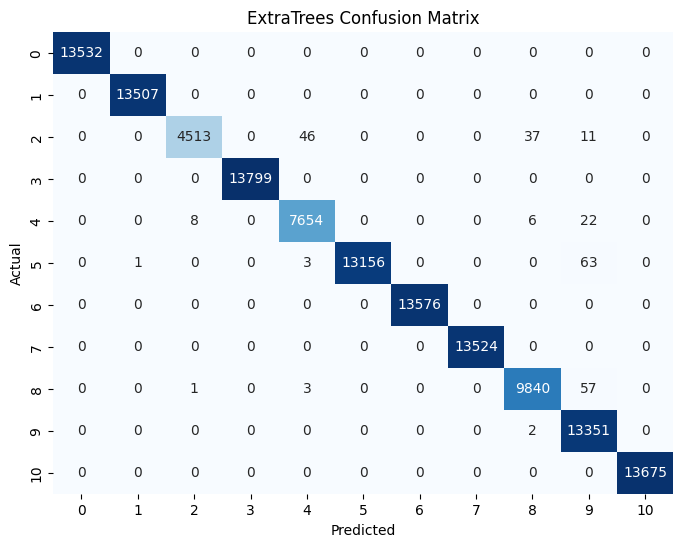

In [16]:
X = X.astype('float32')

et_model = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=1)
et_model.fit(X_train, y_train)

y_pred_et = et_model.predict(X_test)

print("ExtraTrees - Classification Report")
print(classification_report(y_test, y_pred_et))
print("ExtraTrees - Accuracy:", accuracy_score(y_test, y_pred_et))

conf_matrix_et = confusion_matrix(y_test, y_pred_et)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_et, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("ExtraTrees Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()